In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

In [2]:
# Baseline Survey
baseline_file = get_baseline()
runName = os.path.split(baseline_file)[-1].replace('.db', '')

print(runName)

baseline_v2.1_10yrs


In [4]:
# Set up output
outDir = 'test_seasons'

nside = 16
slicer = maf.HealpixSlicer(nside=nside, use_cache=True)
metric = maf.SeasonLengthMetric()
m2 = maf.CountMetric(col='night')
bundle = maf.MetricBundle(metric, slicer, None)
b2 = maf.MetricBundle(m2, slicer, None)

bg = maf.MetricBundleGroup({'season': bundle, 'night': b2}, baseline_file, outDir)


# Behind the scenes stuff to get the simulated data and set up the slicer so we can test ONE point
bg.set_current('')
bg.get_data('')
simData = bg.sim_data
bundle.slicer.setup_slicer(simData)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [5]:
# Find a good spot on the sky with lots of visits
lenvisits = []
for s in bundle.slicer:
    lenvisits.append(len(s['idxs']))
lenvisits = np.array(lenvisits)
x = np.where(lenvisits == np.max(lenvisits))[0][0]

bundle.slicer[x]

{'idxs': array([ 240354,  240404, 1282012, ..., 1201043,  643115,  643165]),
 'slice_point': {'sid': 2593,
  'ra': 0.15707963267948966,
  'dec': -0.7852913518731985,
  'nside': 16,
  'gall': 5.44072959958684,
  'galb': -1.2543627336334444}}

In [6]:
from astropy.time import Time
from astropy.coordinates import get_sun
from astropy.coordinates import EarthLocation

loc = EarthLocation.of_site('Cerro Pachon')
t = Time('2024-09-22T00:00:00.00', format='isot', scale='utc', location=loc)
print('Time', t.utc.mjd)
print('sun RA', get_sun(t).ra.deg, t.utc.mjd)
print('local sidereal time to adjust to season start', t.sidereal_time('mean').deg)

Time 60575.0
sun RA 179.20796047239727 60575.0
local sidereal time to adjust to season start 290.6128387847666


In [7]:
def calcSeason(ra, time):
    """Calculate the 'season' in the survey for a series of ra/time values of an observation.
    Based only on the RA of the point on the sky, it calculates the 'season' based on when the sun
    passes through this RA (this marks the start of a 'season').
    
    Note that seasons should be calculated using the RA of a fixed point on the sky, such as 
    the slicePoint['ra'] if calculating season values for a series of opsim pointings on the sky.
    To convert to integer seasons, use np.floor(seasons)
    
    Parameters
    ----------
    ra : `float`
        The RA (in degrees) of the point on the sky
    time : `np.ndarray`
        The times of the observations, in MJD days

    Returns
    -------
    seasons : `np.array`
        The season values, as floats.
    """
    # A reference time and sun RA location to anchor the location of the Sun
    # This time was chosen as it is close to the expected start of the survey.
    refTime = 60575.0
    refSunRA = 179.20796047239727
    # Calculate the fraction of the sphere/"year" for this location
    offset = (ra - refSunRA)/ 360 * 365.25
    # Calculate when the seasons should begin
    seasonBegan = refTime + offset 
    # Calculate the season value for each point.
    seasons = (time - seasonBegan) / 365.25 
    # (usually) Set first season at this point to 0
    seasons = seasons - np.floor(np.min(seasons))
    return seasons
    # The reference values can be evaluated using:    
    #from astropy.time import Time
    #from astropy.coordinates import get_sun
    #from astropy.coordinates import EarthLocation
    #loc = EarthLocation.of_site('Cerro Pachon')
    #t = Time('2024-09-22T00:00:00.00', format='isot', scale='utc', location=loc)
    #print('Ref time', t.utc.mjd)
    #print('Ref sun RA', get_sun(t).ra.deg, t.utc.mjd)
    #print('local sidereal time at season start', t.sidereal_time('apparent').deg)

In [9]:
#x = 2593
#x = 2999
#x = 890
x = 2645
obsidx = slicer[x]['idxs']
ss = np.sort(simData[obsidx], order='observationStartMJD')
seasons = calcSeason(np.degrees(slicer[x]['slice_point']['ra']), ss['observationStartMJD'])
intseason = np.floor(seasons)
print(len(ss), ss['fieldRA'].min(), ss['fieldRA'].max(), np.degrees(slicer[x]['slice_point']['ra']),
        ss['fieldDec'].mean(), len(obsidx))

804 318.4979297253901 323.6007761169855 321.0 -44.990915196581106 804


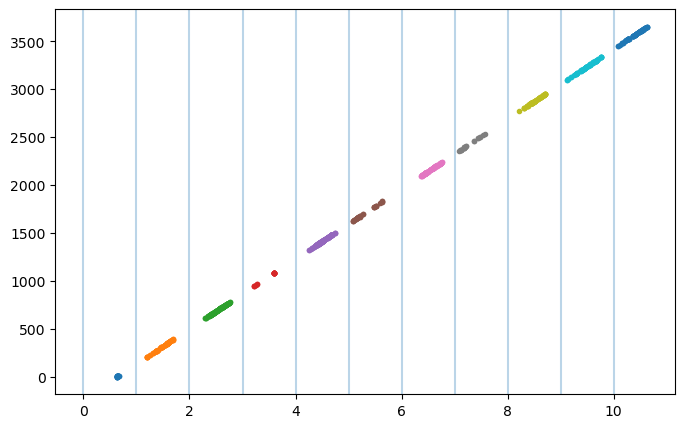

In [10]:
plt.figure(figsize=(8,5))
for s in np.unique(intseason):
    match = np.where(intseason == s)
    plt.plot(seasons[match], ss['night'][match], linestyle='', marker='.')
for n in range(0, 11):
    plt.axvline(n, alpha=0.3)

In [11]:
seasongaps = 106
xx = np.where(np.diff(ss['night'])> seasongaps )[0]
qq = np.where(np.diff(np.floor(seasons)) > 0)[0]
xx, qq, np.floor(seasons)
pd.DataFrame([np.diff(ss['night'])[xx], ss['night'][xx-1], ss['night'][xx], 
              ss['night'][xx+1],seasons[xx-1], seasons[xx], seasons[xx+1]],
            index=['delta night', 'n-1', 'n', 'n+1', 'season-1', 'season', 'season+1'])

,0,1,2,3,4,5,6,7,8,9,10
delta night,194.000000,219.000000,165.000000,117.000000,240.000000,126.000000,265.000000,122.000000,240.000000,150.000000,118.000000
n-1,13.000000,390.000000,778.000000,963.000000,1085.000000,1501.000000,1829.000000,2238.000000,2520.000000,2950.000000,3334.000000
n,13.000000,390.000000,778.000000,963.000000,1085.000000,1501.000000,1829.000000,2238.000000,2533.000000,2950.000000,3334.000000
n+1,207.000000,609.000000,943.000000,1080.000000,1325.000000,1627.000000,2094.000000,2360.000000,2773.000000,3100.000000,3452.000000
season-1,0.664368,1.696707,2.758889,3.266205,3.599354,4.738410,5.636235,6.756167,7.528375,8.705616,9.756887
season,0.664432,1.696773,2.758951,3.266270,3.599360,4.738490,5.636264,6.756233,7.564099,8.705682,9.756888
season+1,1.196557,2.296914,3.211455,3.585981,4.257245,5.084298,6.362446,7.091171,8.221949,9.117111,10.080853


In [12]:
bg.run_all()

{'SkyMap': 1, 'Histogram': 2}

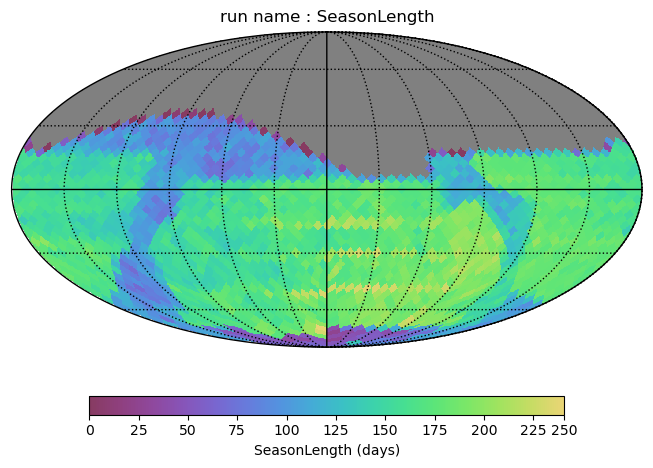

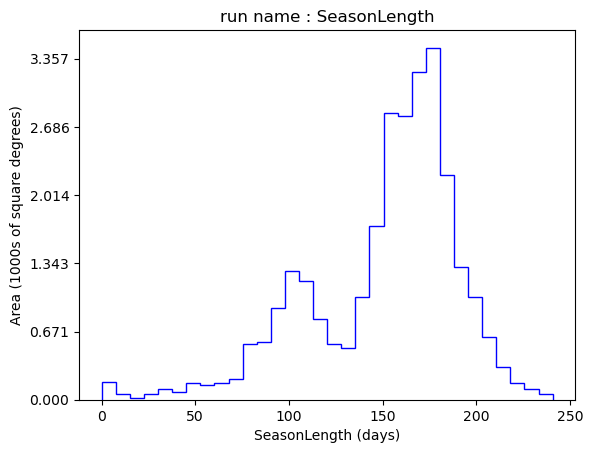

In [13]:
bundle.plot()

In [15]:
# Check every point against gaps in nights
for s in slicer:
    obsidx = s['idxs']
    if len(obsidx) > 3:
        ss = np.sort(simData[obsidx], order='observationStartMJD')
        seasons = calcSeason(np.degrees(s['slice_point']['ra']), ss['observationStartMJD'])
        intseasons = np.floor(seasons)
        xx = np.where(np.diff(ss['night']) > seasongaps)[0]
        qq = np.where(np.diff(intseasons) > 0)[0]
        
        if not np.all(xx == qq):
            print(s['slice_point']['sid'])


/var/folders/05/z_zc9f654c5dlw06t4s_d68w0000gn/T/ipykernel_58347/3121727132.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not np.all(xx == qq):


807
890
932
1086
1091
1098
1099
1103
1105
1106
1120
1184
1301
1360
1374
1376
1380
1381
1431
1433
1434
1435
1436
1612
1705
1768
1890
1891
1896
1928
1946
1957
1994
2018
2021
2022
2023
2057
2058
2071
2072
2073
2077
2078
2079
2080
2083
2087
2088
2122
2123
2134
2135
2136
2137
2138
2139
2141
2142
2143
2144
2145
2146
2147
2149
2150
2151
2186
2199
2200
2201
2202
2204
2205
2206
2207
2208
2211
2213
2215
2216
2250
2251
2264
2266
2268
2270
2271
2272
2281
2337
2339
2341
2361
2378
2380
2394
2396
2397
2403
2404
2457
2460
2461
2468
2469
2473
2506
2521
2522
2524
2525
2532
2540
2569
2583
2584
2588
2592
2594
2598
2599
2602
2617
2618
2643
2644
2645
2646
2647
2649
2650
2652
2658
2669
2700
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2718
2751
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2767
2770
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2813
2817
2842
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2860
2885
2886
2888
2890
2891
2892
2893
2894
2899
291